In [ ]:
# The way this tutorial uses the `TimeDistributed` layer requires TF>=2.10
import sys
#!{sys.executable} -m pip install -U "tensorflow>=2.10.0"

In [11]:
#!{sys.executable} -m pip install remotezip tqdm opencv-python
#!{sys.executable} -m pip install -q git+https://github.com/tensorflow/docs

In [12]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

In [13]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [15]:
def list_files_from_zip_url(zip_url):
    """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
    """
    files = []
    with rz.RemoteZip(zip_url) as zip:
        for zip_info in zip.infolist():
            files.append(zip_info.filename)
    return files

In [16]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

In [17]:
def get_class(fname):
    """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
    """
    return fname.split('_')[-3]

In [18]:
def get_files_per_class(files):
    """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
    """
    files_for_class = collections.defaultdict(list)
    for fname in files:
        class_name = get_class(fname)
        files_for_class[class_name].append(fname)
    return files_for_class

In [20]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [21]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


In [25]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
    """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
    """
    files_subset = dict()

    for class_name in classes:
        class_files = files_for_class[class_name]
        files_subset[class_name] = class_files[:files_per_class]

    return files_subset

In [26]:
NUM_CLASSES = 10
FILES_PER_CLASS = 50

In [27]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

In [28]:
def download_from_zip(zip_url, to_dir, file_names):
    """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
    """
    with rz.RemoteZip(zip_url) as zip:
        for fn in tqdm.tqdm(file_names):
            class_name = get_class(fn)
            zip.extract(fn, str(to_dir / class_name))
            unzipped_file = to_dir / class_name / fn
            
            fn = pathlib.Path(fn).parts[-1]
            output_file = to_dir / class_name / fn
            unzipped_file.rename(output_file)

In [29]:
def split_class_lists(files_for_class, count):
    """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
    """
    split_files = []
    remainder = {}
    for cls in files_for_class:
        split_files.extend(files_for_class[cls][:count])
        remainder[cls] = files_for_class[cls][count:]
    return split_files, remainder

In [30]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):
    """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
    """
    files = list_files_from_zip_url(zip_url)
    for f in files:
        path = os.path.normpath(f)
        tokens = path.split(os.sep)
        if len(tokens) <= 2:
            files.remove(f) # Remove that item from the list if it does not have a filename

    files_for_class = get_files_per_class(files)

    classes = list(files_for_class.keys())[:num_classes]

    for cls in classes:
        random.shuffle(files_for_class[cls])

    # Only use the number of classes you want in the dictionary
    files_for_class = {x: files_for_class[x] for x in classes}

    dirs = {}
    for split_name, split_count in splits.items():
        print(split_name, ":")
        split_dir = download_dir / split_name
        split_files, files_for_class = split_class_lists(files_for_class, split_count)
        download_from_zip(zip_url, split_dir, split_files)
        dirs[split_name] = split_dir

    return dirs

In [31]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir)

train :


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [04:29<00:00,  1.11it/s]


val :


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


test :


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


In [32]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


In [41]:
def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [42]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
    """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
    if ret:
        frame = format_frames(frame, output_size)
        result.append(frame)
    else:
        result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

In [45]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 55.0M    0  238k    0     0   198k      0  0:04:44  0:00:01  0:04:43  198k
  1 55.0M    1  716k    0     0   335k      0  0:02:48  0:00:02  0:02:46  335k
  2 55.0M    2 1130k    0     0   360k      0  0:02:36  0:00:03  0:02:33  361k
  2 55.0M    2 1672k    0     0   396k      0  0:02:22  0:00:04  0:02:18  396k
  3 55.0M    3 2039k    0     0   394k      0  0:02:23  0:00:05  0:02:18  413k
  4 55.0M    4 2501k    0     0   407k      0  0:02:18  0:00:06  0:02:12  458k
  5 55.0M    5 2974k    0     0   417k      0  0:02:15  0:00:07  0:02:08  451k
  6 55.0M    6 3388k    0     0   416k      0  0:02:15  0:00:08  0:02:07  451k
  6 55.0M    6 3834k    0     0   419k      0  0:02

In [47]:
video_path = "End_of_a_jam.ogv"
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(2, 224, 224, 3)

In [46]:
def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=10)
    return embed.embed_file('./animation.gif')


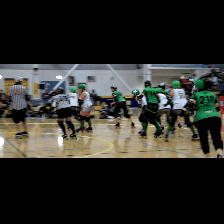

In [48]:
to_gif(sample_video)